In [73]:
"""
calculates potential evaporation from UKCP18 variables based on the method by robinson 2017.
"""
print("entered python succesfully.")
import xarray as xr
import numpy as np
import argparse
import sys
from datetime import datetime
import matplotlib.pyplot as plt

entered python succesfully.


In [67]:
class constants:

    def __init__(self):
        self.t_steam = 373.15  # steam point temperature in kelvin
        self.p_steam = 101325.  # steam point pressure in Pa
        self.a_factors = np.array([13.3185, -1.9760, -0.6445, -0.1299])
        self.epsilon = 0.622  # robinson 2017 eq 3; gill 1982
        self.l = 2.5e6  # J kg-1; latent heat of evaporation of water
        self.c_p = 1010.  # J kg-1 K-1  # specific heat capacity of air
        self.psychrometric = 0.0004  # K-1; psychrometric constant
        # everything is FAO56-grass:
        self.r_s = 70.0  # s m-1  stomatal resistance
        self.alpha = 0.23
        self.emissivity = 0.92
        self.r = 287.05  # J kg-1 K-1, gas consstant of air
        self.t_d = 60*60*24  # seconds day-1: lengthof a day in seconds


def faster_polyval(p, x):
    """
    thank you stackoverflow user Joe Kingston: https://stackoverflow.com/questions/32526388/a-faster-numpy-polynomial
    p=coefficients
    x=array to evalate polynomial
    """
    y = np.zeros(x.shape, dtype=float)
    for i, v in enumerate(p[::-1]):
        y *= x
        y += v
    return y 


def richards_poly(t_a, derive=False):
    """
    Computes the polynomial that forms the exponent in eq 5 Robinson et al 2017 (richards approximation of q_s=f(t_a), 1971). if derive=True, it will compute the first derivative of this term to t_a instead
    deze functie geeft het gewenste resultaat. 

    Parameters
    ----------
    t_a: np.ndarray of air temperature values in Kelvin

    Return
    ------
    a numpy.ndarray same shape as t_a which is the exponent for eq5
    """

    tterm = (1. - cst.t_steam/t_a)
    
    if derive:
        print("calculating richards poly derivative")
        coefficients = cst.a_factors * np.arange(1,5)
        res = faster_polyval(coefficients, tterm) 
        return res * cst.t_steam / (t_a ** 2)
    else:
        print("calculating richards poly")
        coefficients = np.array([0, *cst.a_factors])
        res = faster_polyval(coefficients, tterm) 
        return res


def calc_sat_spechum(es, p_air):
    """
    eq 3 in robinson et al 2017
    """
    print("calculating saturated specific humidity")
    qs = (cst.epsilon * es) / (p_air - (1-cst.epsilon)*es)
    return qs


def calc_delta_qs(e_s, t_a, q_s, p_air):
    """
    eq6 robinson et al 2017
    """
    print("calculating delta q_s")
    delta = (richards_poly(t_a, derive=True) * p_air * q_s) / (p_air - (1.-cst.epsilon) * e_s)
    return delta


# def calc_delta_es(t_a):
#     """
#     Derive e_s with respect to t_air.

#     Derivation of the implementation:
#     d(e_s)/d(t_a) = d(p_steam * exp(richards-polynomial))/d(t_a)
#                   = p_steam * exp(richards-polynomial) * d(richards-polynomial)/d(t_a)
#     """
#     print("calculating delta_es")
#     return cst.p_steam * np.exp(richards_poly(t_a)) * richards_poly(t_a, derive=True)


def calc_eto_ceh_xr(t_a, p_air, netlongwavedown, netshortwavedown, u_10, q_a, allow_neg=False):
    """
    Function to estimate reference ET (ETo) roughly following the method used to produce CHESS-PE ([2]) using the reference crop defined in `FAO 56 paper <http://www.fao.org/docrep/X0490E/X0490E00.htm>`_ [1]_

    I did not calculate the specific humidiy and instead used the vapour pressure deficit as in Monteith et al. 1965, as I don't know why they did not also do that. They refer to some other publication where q_s is used instead of e_s, but there it is also not explained why. This impacts the deficit term in the aerodynamic component and the delta term.

    Parameters
    ----------

    Returns
    -------

    References
    ----------

    .. [1] Allen, R. G., Pereira, L. S., Raes, D., & Smith, M. (1998). Crop evapotranspiration-Guidelines for computing crop water requirements-FAO Irrigation and drainage paper 56. FAO, Rome, 300(9), D05109.

    .. [2] Robinson, E. L., Blyth, E. M., Clark, D. B., Finch, J., & Rudd, A. C. (2017). Trends in atmospheric evaporative demand in Great Britain using high-resolution meteorological data. Hydrology and Earth System Sciences, 21(2), 1189-1224.
    """
    print("Start calculating PE...")

    # calculate the derivative of saturated vapour pressure with respect to air temperature. this does not equate eq 6 in Robinson et al. 2017, see function description.
    e_s = cst.p_steam * np.exp(richards_poly(t_a))
    q_s = calc_sat_spechum(e_s, p_air)
    delta_qs = calc_delta_qs(e_s, t_a, q_s, p_air)

    # eq 7: calculate net radiation from the short- and longwave downwelling radiation, with surface temperature being approximated by air temperature and assuming G is zero
    # R_n = SWnet + LWnet = Sd - cst.alpha*Sd + cst.emissivity * Ld - cst.emissivity * cst.stefboltz * T_a**4
    
    A = netshortwavedown + netlongwavedown  # = R_n - G, but G is assumed to be 0

    # eq 9: air density
    rho_air = p_air / (cst.r*t_a)

    # eq 10
    r_a = 278./u_10  # aerodynamic resistance for a reference crop with height 0.12 m
    
    # denominator for eq 11/12.
    denominator = delta_qs + cst.psychrometric * (1 + (cst.r_s/r_a))
    
    # eq 11
    radiative_component = (delta_qs * A) / denominator
    # eq 12
    aerodynamic_component =  (cst.c_p*rho_air/r_a) * (q_s - q_a) / denominator
    
    print("shapes and sizes of variables:")
    print(f"e_s: {e_s.shape}")
    print(f"q_s: {q_s.shape}")
    print(f"delta_qs: {delta_qs.shape}")
    print(f"A: {A.shape}")
    print(f"rho_air: {rho_air.shape}")
    print(f"r_a: {r_a.shape}")
    print(f"denominator: {denominator.shape}")
    print(f"radiative_component: {radiative_component.shape}")
    print(f"aerodynamic_component: {aerodynamic_component.shape}")

    # calculate potential evaporation
    pe = (radiative_component + aerodynamic_component) * cst.t_d / cst.l
    return pe

Main below

In [68]:
varlist = "huss,psl,rls,rss,sfcWind,tas".split(',')
input_path_format = "/home/users/nelerey/data/toydata_3x3/{var}_rcp85_land-rcm_uk_12km_01_day_19801201-20801130.nc"
output_path = "/home/users/nelerey/data/toydata_3x3/pet_rcp85_land-rcm_uk_12km_01_day_19801201-20801130.nc"

# load data
pathsdict = dict([[v, input_path_format.format(var=v)] for v in varlist])
datadict = {}
for key in pathsdict:
    # if concat_dim:
    #    datadict[key] = xr.open_mfdataset(pathsdict[key], concat_dim=concat_dim,
    #                                      chunks={'projection_x_coordinate': 15, 'projection_y_coordinate': 15})
    #else:
    datadict[key] = xr.open_dataset(pathsdict[key])[key]
# convert units where needed
datadict['psl'] = datadict['psl'] * 100  # hPa to Pa
datadict['tas'] = datadict['tas'] + 273.15  # degC to K
print("Data loaded and units of psl and tas converted. \ndatadict: \n", datadict)

Data loaded and units of psl and tas converted. 
datadict: 
 {'huss': <xarray.DataArray 'huss' (ensemble_member: 1, time: 36000, projection_y_coordinate: 3, projection_x_coordinate: 3)>
[324000 values with dtype=float32]
Coordinates:
  * ensemble_member          (ensemble_member) int32 1
  * projection_y_coordinate  (projection_y_coordinate) float64 1.98e+05 ... 2.22e+05
  * projection_x_coordinate  (projection_x_coordinate) float64 5.58e+05 ... 5.82e+05
    ensemble_member_id       (ensemble_member) |S27 ...
    grid_latitude            (projection_y_coordinate, projection_x_coordinate) float64 ...
    grid_longitude           (projection_y_coordinate, projection_x_coordinate) float64 ...
  * time                     (time) object 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
    month_number             (time) int32 ...
    year                     (time) int32 ...
    yyyymmdd                 (time) |S64 ...
Attributes:
    standard_name:  specific_humidity
    long_name:      Specifi

In [71]:
# calculate pet
cst = constants()

pet_values = calc_eto_ceh_xr(
    t_a=datadict['tas'].values,
    p_air=datadict['psl'].values,
    netlongwavedown=datadict['rls'].values,
    netshortwavedown=datadict['rss'].values,
    u_10=datadict['sfcWind'].values,
    q_a=datadict['huss'].values
)
pet = xr.DataArray(pet_values, datadict['tas'].coords, datadict['tas'].dims)
print("PE calculated: \n", pet, "\n, start preparing for export...")

allow_neg=False
if not allow_neg:
    pet = pet.where(pet > 0., 0)  # pe is preserved where condition is true, "other" is applied where condition is false

pet.name = "pet"  #EvApOtRaNsPiRaTiOn

# bnds caused problems with bias correction before and we don't necessarily need it.
# pet = pet.drop_dims('bnds')

Start calculating PE...
calculating richards poly
calculating saturated specific humidity
calculating delta q_s
calculating richards poly derivative
shapes and sizes of variables:
e_s: (1, 36000, 3, 3)
q_s: (1, 36000, 3, 3)
delta_qs: (1, 36000, 3, 3)
A: (1, 36000, 3, 3)
rho_air: (1, 36000, 3, 3)
r_a: (1, 36000, 3, 3)
denominator: (1, 36000, 3, 3)
radiative_component: (1, 36000, 3, 3)
aerodynamic_component: (1, 36000, 3, 3)
PE calculated: 
 <xarray.DataArray (ensemble_member: 1, time: 36000, projection_y_coordinate: 3, projection_x_coordinate: 3)>
array([[[[0.436416, ..., 0.537454],
         ...,
         [0.380202, ..., 0.415912]],

        ...,

        [[0.144125, ..., 0.261731],
         ...,
         [0.188339, ..., 0.219347]]]])
Coordinates:
  * ensemble_member          (ensemble_member) int32 1
  * projection_y_coordinate  (projection_y_coordinate) float64 1.98e+05 ... 2.22e+05
  * projection_x_coordinate  (projection_x_coordinate) float64 5.58e+05 ... 5.82e+05
    ensemble_membe

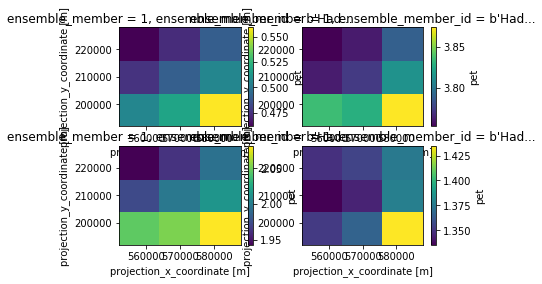

In [72]:
mean_seas = pet.groupby("time.season").mean('time')
f,ax = plt.subplots(2,2)
for i in range(4):
    mean_seas.isel(season=i).plot(ax=ax.flat[i])

In [231]:
datadict['huss']

<xarray.DataArray 'huss' (ensemble_member: 1, time: 36000, projection_y_coordinate: 3, projection_x_coordinate: 3)>
array([[[[0.004827, ..., 0.00487 ],
         ...,
         [0.004914, ..., 0.004945]],

        ...,

        [[0.005735, ..., 0.005816],
         ...,
         [0.005649, ..., 0.005677]]]], dtype=float32)
Coordinates:
  * ensemble_member          (ensemble_member) int32 1
  * projection_y_coordinate  (projection_y_coordinate) float64 1.98e+05 ... 2.22e+05
  * projection_x_coordinate  (projection_x_coordinate) float64 5.58e+05 ... 5.82e+05
    ensemble_member_id       (ensemble_member) |S27 ...
    grid_latitude            (projection_y_coordinate, projection_x_coordinate) float64 ...
    grid_longitude           (projection_y_coordinate, projection_x_coordinate) float64 ...
  * time                     (time) object 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
    month_number             (time) int32 ...
    year                     (time) int32 ...
    yyyymmdd         

In [ ]:
# prepare for export
attributes = {
    'creation_script': sys.argv[0] + " (N. Reyniers)",
    'creation_time': datetime.now().strftime("%d-%m-%Y %H:%M"),
    'standard_name': 'water_reference_evaporation_amount',
    'long_name': 'FAO56/Robinson reference evaporation amount',
    'units': 'kg m-2',
    'label_units': 'kg m-2',
    'plot_label': 'ET0 (kg m-2)',
    'description': 'Reference crop potential evaporation (kg m-2) calculated from rls, rss, psl, huss, tas, sfcWind based on Robinson et al. (2017) to match CHESS-PE',
    'units_equivalent': 'mm',
    'PE_calculation_method': 'Penman-Monteith as implemented in Robinson et al. (2017), using the FAO56 reference crop (Allen et al., 1998)',
    'references': '[1] Robinson, E. L., et al. "Trends in atmospheric evaporative demand in Great Britain using high-resolution meteorological data." Hydrology and Earth System Sciences 21.2 (2017): 1189-1224. [2] Allen, R. G., et al. \"Crop evapotranspiration-Guidelines for computing crop water requirements-FAO Irrigation and drainage paper 56.\" Fao, Rome 300.9 (1998): D05109.',
    'input_variable_names': ', '.join(list(pathsdict.keys()))
}
input_attributes = dict(
    [['input_{}'.format(vn), pathsdict[vn]] for vn in list(pathsdict.keys())]
)
pet = pet.assign_attrs(attributes)
pet = pet.assign_attrs(input_attributes)
pet.to_netcdf(output_path, engine='netcdf4', format='NETCDF4',
              encoding={"pet": {"dtype": "float32"}})
print("Succesfully exported.")

Compare to CEH script:

In [166]:
tair = datadict['tas']
tref = 1.0-(cst.t_steam/tair)
sumat = sum([cst.a_factors[i]*(tref**(i+1)) for i in range(4)])

In [167]:
richpol = richards_poly(datadict['tas'])

calculating richards poly
-0.1299
-0.6445
-1.976
13.3185
0.0
4


In [174]:
t_a = datadict['tas']
p_air = datadict['psl']

e_s = cst.p_steam * np.exp(richards_poly(t_a))
q_s = calc_sat_spechum(e_s, p_air) 
delta = calc_delta_qs(e_s, t_a, q_s, p_air)


calculating richards poly
-0.1299
-0.6445
-1.976
13.3185
0.0
4
calculating saturated specific humidity
calculating delta q_s
calculating richards poly derivative
-0.5196
-1.9335
-3.952
13.3185
3


In [178]:
def tref(tair):
    # Tr = 1 - Ts/Ta
    tref = 1.0-(cst.t_steam/tair)
    return tref


###############################################################################
# Vapour pressure at saturation esat
###############################################################################
def esat(tref):
    sumat = sum([cst.a_factors[i]*(tref**(i+1)) for i in range(4)])
    esat = cst.p_steam*np.exp(sumat)
    return esat


###############################################################################
# Specific humidity at saturation Qsat
###############################################################################
def qsat(tref, psurf):
    es = esat(tref)
    qsat = cst.epsilon * es/(psurf-((1.0-cst.epsilon)*es))
    return qsat


def calc_Del(tair, psurf):
    tr = tref(tair)
    es = esat(tr)
    qs = qsat(tr, psurf)
    sumat_deriv = sum([cst.a_factors[i]*(i+1)*(tr**i) for i in range(4)])
    Del = psurf * cst.t_steam * sumat_deriv * qs / \
        (tair * tair * (psurf - ((1.0 - cst.epsilon) * es)))
    return Del
Del = calc_Del(datadict['tas'], datadict['psl'])

Check with the fao version


In [210]:
fao56 = xr.open_dataset("/home/users/nelerey/data/toydata_3x3/"\
                        "evpot-fao56_rcp85_land-rcm_uk_12km_01_day_19801201-20801130.nc")

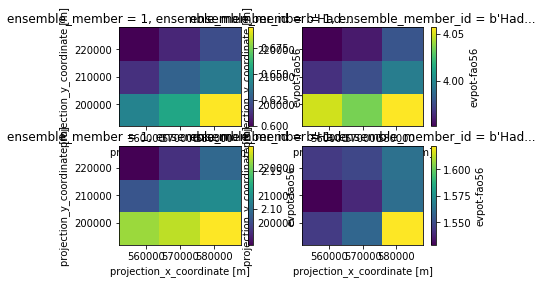

In [211]:
mean_seas_fao = fao56['evpot-fao56'].isel(bnds=0).groupby("time.season").mean('time')
f,ax = plt.subplots(2,2)
for i in range(4):
    mean_seas_fao.isel(season=i).plot(ax=ax.flat[i])

In [222]:
fao56['evpot-fao56']

<xarray.DataArray 'evpot-fao56' (ensemble_member: 1, time: 36000, projection_y_coordinate: 3, projection_x_coordinate: 3, bnds: 2)>
array([[[[[0.57, 0.57],
          ...,
          [0.68, 0.68]],

         ...,

         [[0.51, 0.51],
          ...,
          [0.55, 0.55]]],


        ...,


        [[[0.33, 0.33],
          ...,
          [0.45, 0.45]],

         ...,

         [[0.38, 0.38],
          ...,
          [0.4 , 0.4 ]]]]])
Coordinates:
  * ensemble_member          (ensemble_member) int32 1
  * projection_y_coordinate  (projection_y_coordinate) float64 1.98e+05 ... 2.22e+05
  * projection_x_coordinate  (projection_x_coordinate) float64 5.58e+05 ... 5.82e+05
    ensemble_member_id       (ensemble_member) |S27 b'HadREM3-GA705-r001i1p00000 '
    grid_latitude            (projection_y_coordinate, projection_x_coordinate) float64 2.214 ... 2.364
    grid_longitude           (projection_y_coordinate, projection_x_coordinate) float64 -10.89 ... -10.62
  * time                    

# Check result with rosie version

In [5]:
pet_new = xr.open_dataset("/home/users/nelerey/data/PE/ETo-chess/pet_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc")
pet_rosie = xr.open_dataset("/home/users/nelerey/data/PE/rosie-chess/pet_UKCP18_ensemble01_changevarname.nc")

<xarray.Dataset>
Dimensions:  (time: 35640, x: 82, y: 112)
Coordinates:
  * time     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * x        (x) float64 -2.1e+05 -1.98e+05 -1.86e+05 ... 7.5e+05 7.62e+05
  * y        (y) float64 -1.02e+05 -9e+04 -7.8e+04 ... 1.218e+06 1.23e+06
Data variables:
    var      (time, y, x) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Oct 30 11:31:25 2020: cdo chname,time,ymd pet_UKCP18_en...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [74]:
pet_rosie_val = pet_rosie['var'][:3570].values
pet_new_val = pet_new["pet"][0, 30:].values
print(pet_new_val.shape, pet_rosie_val.shape)

(3570, 112, 82) (3570, 112, 82)


In [75]:
diff = pet_rosie_val - pet_new_val
tempavg = np.mean(diff, axis=0)

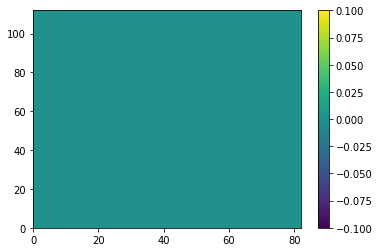

In [76]:
im= plt.pcolormesh(tempavg)
plt.colorbar(im)

In [77]:
# make use of 30 day monthys to calculate monthly averages:
monthlydifsdict = {}
for t in range(10):
    for m in range(12):
        if m not in monthlydifsdict.keys():
            monthlydifsdict[m] = []
        start = t*12*30 + m*30
        stop = t*12*30 + (m+1)*30
        monthlydifsdict[m].append(diff[start:stop])

monthlydifsdict = {m: np.concatenate(arr) for m,arr in monthlydifsdict.items()}
monthlymeandifsdict = {m: np.mean(arr, axis=0) for m,arr in monthlydifsdict.items()}

In [78]:
monthlymeandifsdict[10].shape

(112, 82)

In [79]:
# plot monthly averages

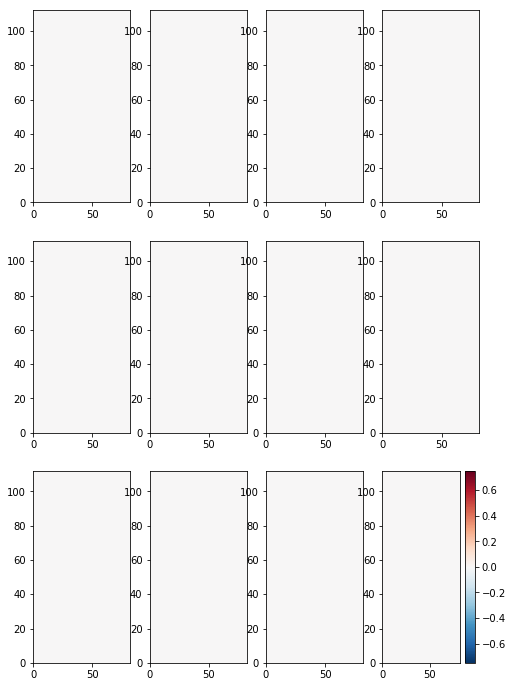

In [80]:
f,ax = plt.subplots(3,4, figsize=(8,12))
for i in range(12): 
    im = ax.flat[i].pcolormesh(monthlymeandifsdict[i], vmin = -0.75, vmax=0.75, cmap="RdBu_r")
plt.colorbar(im)